# Estimate haplotype ages

## Setup

In [1]:
%run setup.ipynb
%matplotlib inline
import hapclust

### Data setup 

In [2]:
# load data
callset_haps = np.load('../../data/phase2/haps.npz')
haps = allel.HaplotypeArray(callset_haps['haplotypes'])
pos = allel.SortedIndex(callset_haps['POS'])
ann = callset_haps['ANN']

In [3]:
pos_kdr_s = 2422651
pos_kdr_f = 2422652

In [4]:
collections.Counter(ann['Annotation'])

Counter({b'3_prime_UTR_variant': 6959,
         b'5_prime_UTR_premature_start_codon_': 594,
         b'5_prime_UTR_variant': 3473,
         b'downstream_gene_variant': 47736,
         b'initiator_codon_variant': 5,
         b'intergenic_region': 115619,
         b'intragenic_variant': 61,
         b'intron_variant': 88490,
         b'missense_variant': 15634,
         b'missense_variant&splice_region_var': 209,
         b'splice_acceptor_variant&intron_var': 61,
         b'splice_donor_variant&intron_varian': 61,
         b'splice_region_variant': 78,
         b'splice_region_variant&intron_varia': 1670,
         b'splice_region_variant&stop_retaine': 12,
         b'splice_region_variant&synonymous_v': 240,
         b'start_lost': 14,
         b'stop_gained': 125,
         b'stop_gained&splice_region_variant': 1,
         b'stop_lost': 4,
         b'stop_lost&splice_region_variant': 11,
         b'stop_retained_variant': 12,
         b'synonymous_variant': 22315,
         b'upstream_ge

In [5]:
# perform allele count - needed to locate singletons  
ac = haps.count_alleles(max_allele=3)
ac[:1]

,0,1,2,3
0,2283,1,0,0


### Setup missense variation

In [6]:
tbl_variants_selected = etl.frompickle('../../data/phase2/tbl_variants_missense_selected.pkl')
tbl_variants_selected

0|CHROM,1|POS,2|num_alleles,3|REF,4|ALT,5|AC,6|ALTIX,7|FILTER_PASS,8|NoCoverage,9|LowCoverage,10|HighCoverage,11|LowMQ,12|HighMQ0,13|RepeatDUST,14|RepeatMasker,15|RepeatTRF,16|FS,17|HRun,18|QD,19|ReadPosRankSum,20|SNPEFF_Allele,21|SNPEFF_Annotation,22|SNPEFF_HGVS_c,23|SNPEFF_HGVS_p,24|SNPEFF_Feature_ID,25|SNPEFF_CDS_pos,26|AF_AOcol,27|AF_BFcol,28|AF_GHcol,29|AF_CIcol,30|AF_GNcol,31|AF_GW,32|AF_GM,33|AF_GNgam,34|AF_BFgam,35|AF_GHgam,36|AF_CMgam,37|AF_UGgam,38|AF_GAgam,39|AF_GQgam,40|AF_FRgam,41|AF_KE,42|check_allele,43|exon_start,44|exon_end,45|exon,46|AGAP004707-RA,47|AGAP004707-RB,48|AGAP004707-RC,49|Davies-C1N2,50|Davies-C3N2,51|Davies-C5N2,52|Davies-C7N2,53|Davies-C8N2,54|Davies-C10N2,55|Davies-C11N2,56|Davies-C1N9,57|Davies-C8N9,58|Davies-C1N9ck
2L,2390177,2,G,A,215,0,True,0,4,13,0,0,False,False,False,0.479,1,19.5,1.877,A,missense_variant,n.761G>A,p.Arg254Lys,AGAP004707-RA,761,0.0,0.0,0.00909090909091,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.313131313131,0.0,0.202898550725,0.0,0.0,0.0,True,2390129,2390341,7,R254K,R254K,R254K,R260K,R217K,R260K,R260K,R271K,R260K,R260K,R260K,R271K,R260K
2L,2391228,3,G,C,38,0,True,0,0,15,0,0,False,False,False,1.1973,0,15.109,-1.2637,C,missense_variant,n.1204G>C,p.Val402Leu,AGAP004707-RA,1204,0.0,0.0733333333333,0.127272727273,0.0845070422535,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,2391156,2391320,10,V402L,V402L,V402L,V408L,V365L,,V408L,V419L,V408L,V408L,V408L,V419L,V408L
2L,2391228,3,G,T,14,1,True,0,0,15,0,0,False,False,False,1.1973,0,15.109,-1.2637,None,None,None,None,None,None,0.0,0.06,0.0454545454545,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,2391156,2391320,10,V402L,V402L,V402L,V408L,V365L,,V408L,V419L,V408L,V408L,V408L,V419L,V408L
2L,2399997,2,G,C,41,0,True,0,2,11,0,0,False,False,False,13.234,0,15.469,0.065979,C,missense_variant,n.1396G>C,p.Asp466His,AGAP004707-RA,1396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0690235690236,0.0,0.0,0.0,0.0,0.0,True,2399898,2400173,11i+,D466H,D466H,D466H,D472H,D429H,D417H,D472H,D483H,D472H,D472H,D472H,D483H,D472H
2L,2400071,3,G,A,22,0,True,0,1,14,0,0,False,False,False,2.1289,0,26.594,0.39111,A,missense_variant,n.1470G>A,p.Met490Ile,AGAP004707-RA,1470,0.0,0.0,0.0,0.0,0.0,0.0,0.0307692307692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1875,True,2399898,2400173,11i+,M490I,M490I,M490I,M496I,M453I,M441I,M496I,M507I,M496I,M496I,M496I,M507I,M496I


In [7]:
tbl_selected_redux = (
    tbl_variants_selected
    # TODO add multi-allelics and fails back in
    .eq('num_alleles', 2)
    .true('FILTER_PASS')
    .cut('POS', 'REF', 'ALT', 'AGAP004707-RA')
    .mergeduplicates(key=('POS'))
    .convert('ALT', lambda v: ','.join(v) if len(v) > 1 else v)
    .addfield('label',  lambda rec: '%s:%s>%s %s' % (rec.POS, rec.REF, rec.ALT.ljust(3), rec['AGAP004707-RA'].rjust(6)))
    .sort('POS')
)
tbl_selected_redux.display(vrepr=repr)

0|POS,1|REF,2|ALT,3|AGAP004707-RA,4|label
2390177,'G','A','R254K','2390177:G>A R254K'
2399997,'G','C','D466H','2399997:G>C D466H'
2402466,'G','T','G531V','2402466:G>T G531V'
2407967,'A','C','Q697P','2407967:A>C Q697P'
2416980,'C','T','T791M','2416980:C>T T791M'


In [8]:
lbl_vgsc_missense = tbl_selected_redux.values('label').list()
lbl_vgsc_missense

['2390177:G>A    R254K',
 '2399997:G>C    D466H',
 '2402466:G>T    G531V',
 '2407967:A>C    Q697P',
 '2416980:C>T    T791M',
 '2422651:T>C    L995S',
 '2422652:A>T    L995F',
 '2429556:G>A   V1507I',
 '2429617:T>C   I1527T',
 '2429745:A>T   N1570Y',
 '2429897:A>G   E1597G',
 '2429915:A>C   K1603T',
 '2430424:G>T   A1746S',
 '2430817:G>A   V1853I',
 '2430863:T>C   I1868T',
 '2430880:C>T   P1874S',
 '2430881:C>T   P1874L',
 '2431019:T>C   F1920S',
 '2431079:T>C   I1940T']

In [9]:
pos_selected = tbl_selected_redux.values('POS').array()
pos_selected

array([2390177, 2399997, 2402466, 2407967, 2416980, 2422651, 2422652,
       2429556, 2429617, 2429745, 2429897, 2429915, 2430424, 2430817,
       2430863, 2430880, 2430881, 2431019, 2431079], dtype=int32)

In [10]:
loc_vgsc_missense = pos.locate_keys(pos_selected)
np.count_nonzero(loc_vgsc_missense)

19

In [11]:
haps_vgsc_missense = haps[loc_vgsc_missense]
haps_vgsc_missense

<HaplotypeArray shape=(19, 2284) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 1 0 0 ... 0 0 0 0 0

## Split up haplotype data into neutral/mutation

Here we divide haplotype data up into two, with an "EHH" set containing no singletons and only neutral biallelic variants, which we'll use for analysis of haplotype sharing, and a "mut" set containing singletons and putatively non-neutral bi-allelic variants that we will use for analysis of mutations on shared haplotypes.

In [12]:
# define types of variants to include in EHH analysis - should be mostly neutral
loc_type_neutral = ((ann['Annotation'] == b'intergenic_region') | 
                    (ann['Annotation'] == b'intron_variant') |
                    (ann['Annotation'] == b'downstream_gene_variant') |
                    (ann['Annotation'] == b'upstream_gene_variant') |
                    (ann['Annotation'] == b'synonymous_variant') |
                    (ann['Annotation'] == b'3_prime_UTR_variant') |
                    (ann['Annotation'] == b'5_prime_UTR_variant') 
                    )
np.count_nonzero(loc_type_neutral), loc_type_neutral.shape

(371793, (390585,))

In [13]:
# locate singletons - will exclude from EHH analysis
# NB the EHH analysis doesn't need the multiallelics 
loc_sgl_bi = (ac[:, :2].min(axis=1) == 1) & (ac.is_biallelic_01())
loc_nosgl_bi = (ac[:, :2].min(axis=1) > 1) & (ac.is_biallelic_01())
np.count_nonzero(loc_sgl_bi), np.count_nonzero(loc_nosgl_bi), loc_nosgl_bi.shape

(113477, 277024, (390585,))

In [14]:
# these are the variants to use for EHH 
loc_ehh = loc_type_neutral & loc_nosgl_bi
np.count_nonzero(loc_ehh), loc_ehh.shape

(265626, (390585,))

In [15]:
# these are the variants to use for mutational distance
# include non-neutral mutations
loc_mut = loc_sgl_bi | ~loc_type_neutral
np.count_nonzero(loc_mut), loc_mut.shape

(124888, (390585,))

In [16]:
haps_mut = haps[loc_mut]
pos_mut = pos[loc_mut]

In [17]:
haps_mut

<HaplotypeArray shape=(124888, 2284) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

In [18]:
haps_ehh = haps[loc_ehh]
pos_ehh = pos[loc_ehh]

In [19]:
#check
pos_mut.locate_key(pos_kdr_s), pos_mut.locate_key(pos_kdr_f)

(12368, 12369)

In [20]:
# read in haplotype metadata to get population
df_haplotypes = phase2_ar1.df_haplotypes
df_haplotypes = df_haplotypes[~df_haplotypes.population.isnull()]
df_haplotypes.head()

,label,ox_code,src_code,population,country,region,contributor,contact,year,m_s,sex,n_sequences,mean_coverage,label_aug
index,,,,,,,,,,,,,,
0,AA0040-Ca,AA0040-C,Twifo_Praso__E2,GHcol,Ghana,Twifo_Praso,David Weetman,,2012.0,M,F,95033368.0,30.99,"AA0040-Ca [Ghana, Twifo_Praso, M, F]"
1,AA0040-Cb,AA0040-C,Twifo_Praso__E2,GHcol,Ghana,Twifo_Praso,David Weetman,,2012.0,M,F,95033368.0,30.99,"AA0040-Cb [Ghana, Twifo_Praso, M, F]"
2,AA0041-Ca,AA0041-C,Twifo_Praso__H3,GHcol,Ghana,Twifo_Praso,David Weetman,,2012.0,M,F,95843804.0,31.70,"AA0041-Ca [Ghana, Twifo_Praso, M, F]"
3,AA0041-Cb,AA0041-C,Twifo_Praso__H3,GHcol,Ghana,Twifo_Praso,David Weetman,,2012.0,M,F,95843804.0,31.70,"AA0041-Cb [Ghana, Twifo_Praso, M, F]"
4,AA0042-Ca,AA0042-C,Takoradi_C7,GHcol,Ghana,Takoradi,David Weetman,,2012.0,M,F,107420666.0,35.65,"AA0042-Ca [Ghana, Takoradi, M, F]"


In [21]:
len(df_haplotypes) / 2

1142.0

## Split flanks

Split haplotype data into L/R flanks on kdr position.

In [22]:
# set core SNP
core_pos = pos_kdr_f

In [23]:
# split the EHH dataset
dist_ehh_right, dist_ehh_left, haps_ehh_right, haps_ehh_left = hapclust.split_flanks(haps_ehh, pos_ehh, core_pos)

In [24]:
# these give the distance from the core position to each downstream variant, moving away from the core
dist_ehh_right

array([     45,      82,     258, ..., 3576562, 3576568, 3576584])

In [25]:
dist_ehh_right.shape, dist_ehh_left.shape, dist_ehh_right.min(), dist_ehh_left.min()

((246752,), (18874,), 45, 108)

In [26]:
# split the mutations dataset
dist_mut_right, dist_mut_left, haps_mut_right, haps_mut_left = hapclust.split_flanks(haps_mut, pos_mut, core_pos)

In [27]:
dist_mut_right

array([      0,     938,    1194, ..., 3575943, 3576417, 3576420])

In [28]:
dist_mut_right.shape, dist_mut_left.shape, dist_mut_right.min(), dist_mut_left.min()

((112519,), (12369,), 0, 1)

In [29]:
haps_ehh_left.shape, haps_ehh_right.shape, haps_mut_left.shape, haps_mut_right.shape

((18874, 2284), (246752, 2284), (12369, 2284), (112519, 2284))

In [30]:
is_accessible = phase2_ar1.accessibility['2L/is_accessible'][:]

## Analyse maximal haplotype sharing ("nearest neighbour" analysis based on prefix sorting)

- nn_spl = neighbour sharing prefix length
- nn_spd = neighbour shared physical distance

In [31]:
nn_idx_sorted_right, nn_spl_right, nn_spd_right, nn_muts_right = hapclust.neighbour_haplotype_sharing(haps_ehh_right, haps_mut_right, dist_ehh_right, dist_mut_right)

In [32]:
nn_idx_sorted_left, nn_spl_left, nn_spd_left, nn_muts_left = hapclust.neighbour_haplotype_sharing(haps_ehh_left, haps_mut_left, dist_ehh_left, dist_mut_left)

In [33]:
nn_spl_right.min(), nn_spl_right.max()

(0, 106280)

In [34]:
nn_spd_right.min(), nn_spd_right.max(), nn_spd_left.min(), nn_spd_left.max()

(45, 1544571, 108, 2371438)

In [35]:
nn_muts_right.min(), nn_muts_right.max(), nn_muts_left.min(), nn_muts_left.max()

(0, 12, 0, 15)

In [36]:
# compute accessible lengths - needed for mutation analysis
nn_spd_right_accessible = hapclust.haplotype_accessible_length(nn_spd_right, core_pos=core_pos, is_accessible=is_accessible, flank='right')
nn_spd_left_accessible = hapclust.haplotype_accessible_length(nn_spd_left, core_pos=core_pos, is_accessible=is_accessible, flank='left')

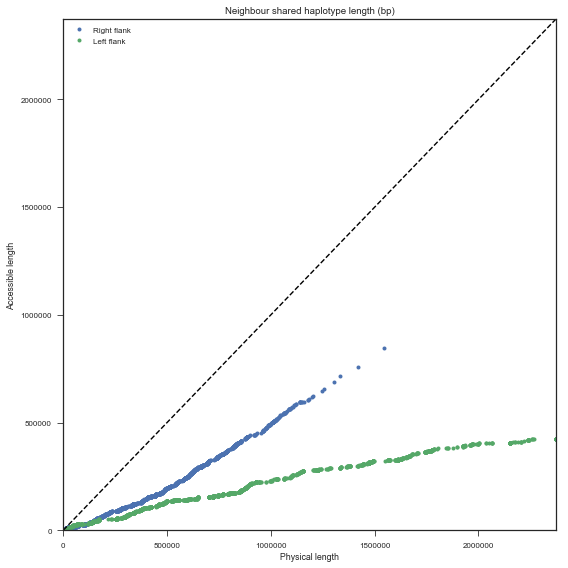

In [37]:
def nn_accessibility_diagnostics():

    # get some diagnostics on accessibility on left versus right flanks
    fig, ax = plt.subplots(figsize=(8, 8))
    x = nn_spd_right
    y = nn_spd_right_accessible
    ax.plot(x, y, linestyle=' ', marker='o', markersize=4, label='Right flank')
    x = nn_spd_left
    y = nn_spd_left_accessible
    ax.plot(x, y, linestyle=' ', marker='o', markersize=4, label='Left flank')
    ax.set_xlabel('Physical length')
    ax.set_ylabel('Accessible length')
    lim = 0, x.max()
    ax.set_xlim(*lim)
    ax.set_ylim(*lim)
    ax.plot(lim, lim, 'k--')
    ax.legend()
    ax.set_title('Neighbour shared haplotype length (bp)')
    fig.tight_layout()
    

nn_accessibility_diagnostics()

In [38]:
# 1 cM/Mb convert to M/bp
1 / (1e2 * 1e6)

1e-08

In [39]:
# TODO revisit this

# assume constant recombination rate
rr_right = 1.5e-8
# adjust recombination rate on left flank (factor derived from pairwise analysis below)
rr_left = rr_right * 0.26

# assumed mutation rate
mu_right = 3.5e-9
# adjust mutation rate on left flank (factor derived from pairwise analysis below)
mu_left = mu_right * 0.59

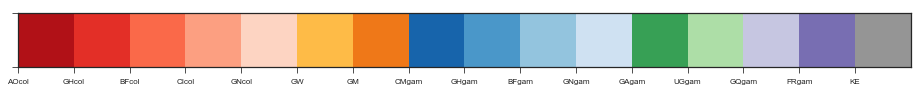

In [42]:
pop_ids = phase2_ar1.pop_ids
pop_colors = phase2_ar1.pop_colors

sns.palplot([pop_colors.get(k, 'k') for k in pop_ids])
plt.gca().set_xticklabels(pop_ids);

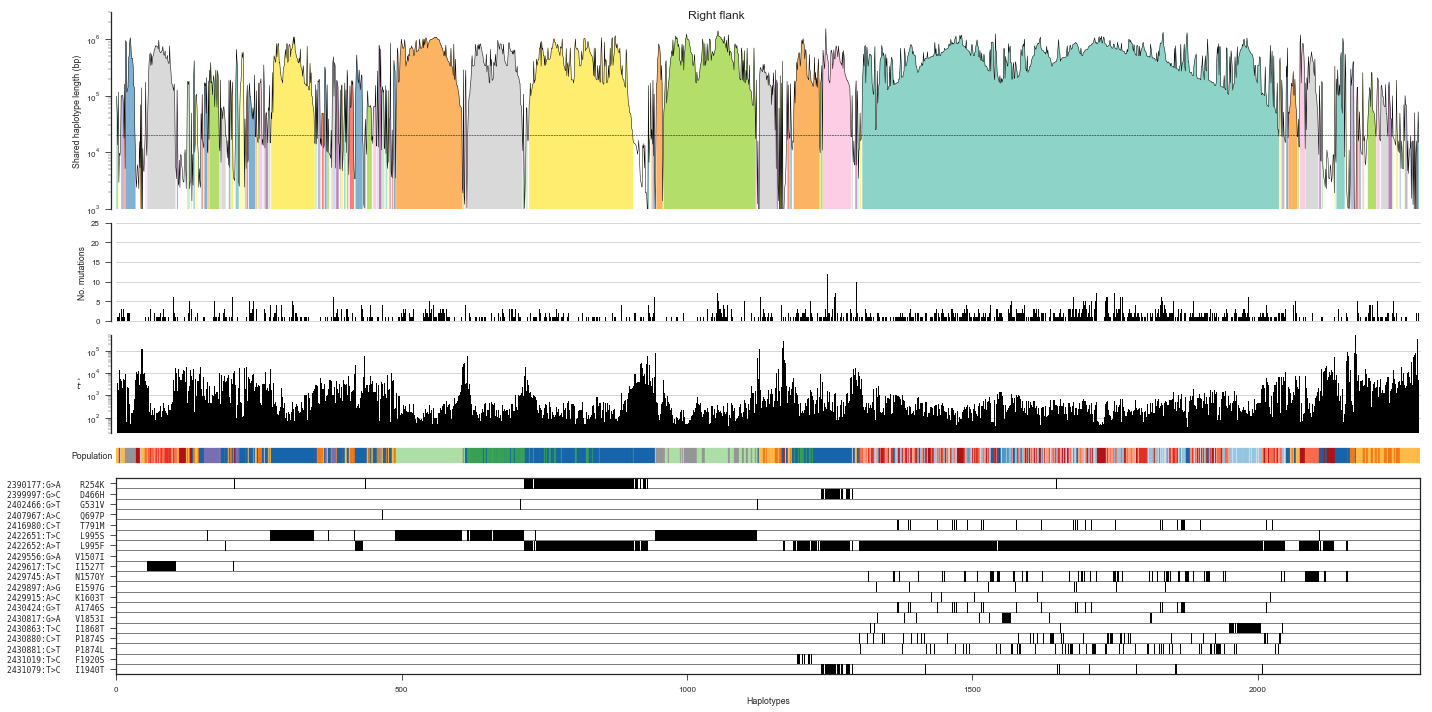

In [43]:
def plot_nn_right_flank():

    pops_right = df_haplotypes.population[nn_idx_sorted_right]
    pop_colors_right = [pop_colors[p] for p in pops_right]

    fig = plt.figure(figsize=(20, 10))
    hapclust.fig_neighbour_haplotype_sharing(nspd=nn_spd_right, 
                                             nspd_accessible=nn_spd_right_accessible,
                                             muts=nn_muts_right, 
                                             haps_display=haps_vgsc_missense[:, nn_idx_sorted_right],
                                             haps_display_vlbl=lbl_vgsc_missense,
                                             pop_colors=pop_colors_right,
                                             nspd_cut=2e4,
                                             nspd_ylim=(1e3, 3e6),
                                             that_ylim=(2e1, 5e5),
                                             muts_ylim=(0, 25),
                                             mu=mu_right, rr=rr_right,
                                             fig=fig)
    fig.suptitle('Right flank')
    
    
plot_nn_right_flank()

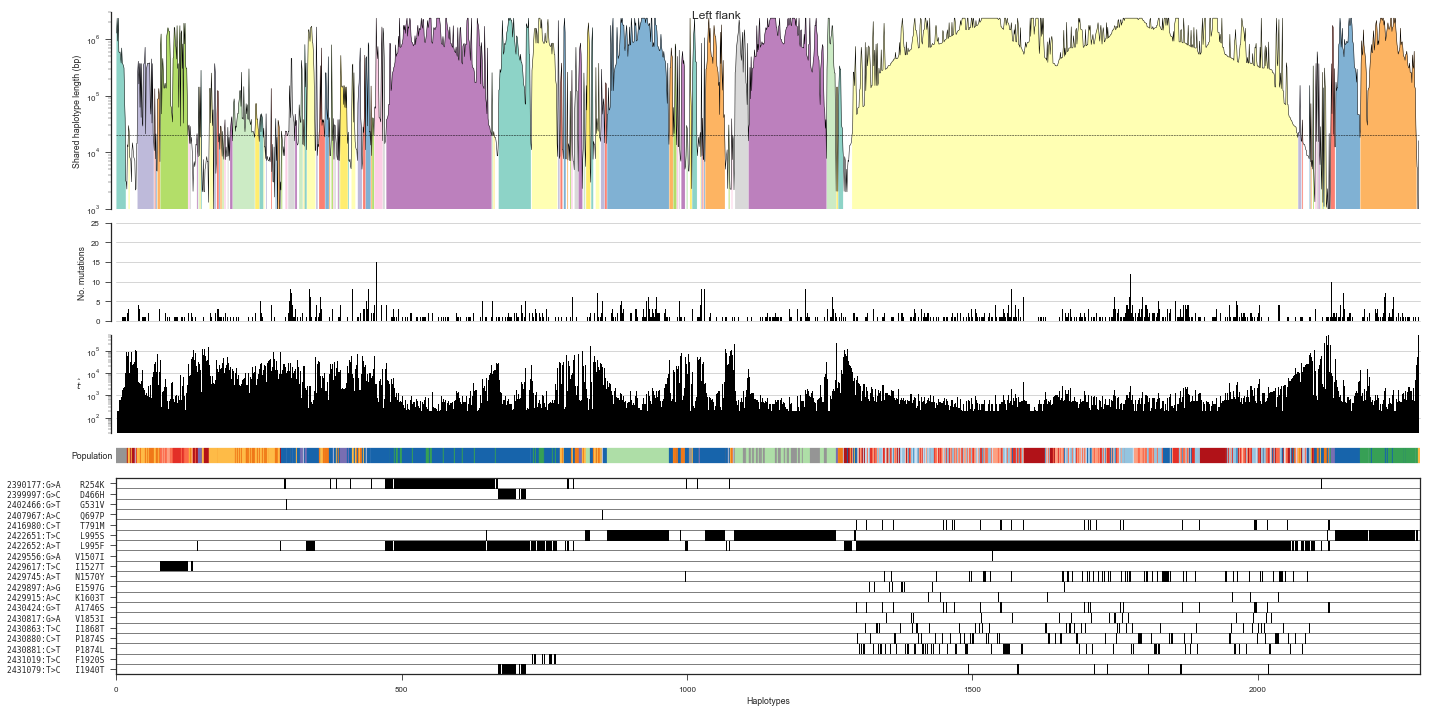

In [44]:
def plot_nn_left_flank():

    pops_left = df_haplotypes.population[nn_idx_sorted_left]
    pop_colors_left = [pop_colors[p] for p in pops_left]

    fig = plt.figure(figsize=(20, 10))
    hapclust.fig_neighbour_haplotype_sharing(nspd=nn_spd_left, 
                                             muts=nn_muts_left, 
                                             nspd_accessible=nn_spd_left_accessible,
                                             haps_display=haps_vgsc_missense[:, nn_idx_sorted_left],
                                             haps_display_vlbl=lbl_vgsc_missense,
                                             pop_colors=pop_colors_left,
                                             nspd_cut=2e4,
                                             nspd_ylim=(1e3, 3e6),
                                             that_ylim=(2e1, 5e5),
                                             muts_ylim=(0, 25),
                                             mu=mu_left, rr=rr_left,
                                             fig=fig)
    fig.suptitle('Left flank')
    
    
plot_nn_left_flank()

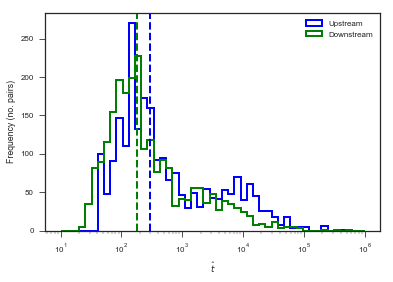

In [45]:
def nn_t_hat_diagnostics():

    # get some diagnostics on estimates of t hat on left versus right flanks

    fig = plt.figure()
    ax = fig.add_subplot(111)
    x = nn_spd_left
    t_hat = (1 + nn_muts_left) / (2 * (nn_spd_left * rr_left + nn_spd_left_accessible * mu_left))
    ax.hist(t_hat[(nn_spd_left > 0)], bins=np.logspace(1, 6, 50), histtype='step', lw=2, label='Upstream', color='b')
    ax.axvline(np.median(t_hat), linestyle='--', color='b', lw=2)
    t_hat = (1 + nn_muts_right) / (2 * (nn_spd_right * rr_right + nn_spd_right_accessible * mu_right))
    ax.hist(t_hat[(nn_spd_right > 0)], bins=np.logspace(1, 6, 50), histtype='step', lw=2, label='Downstream', color='g')
    ax.axvline(np.median(t_hat), linestyle='--', color='g', lw=2)
    ax.set_xscale('log')
    ax.set_xlabel('$\hat{t}$')
    ax.set_ylabel('Frequency (no. pairs)')
    ax.legend()
    
    
nn_t_hat_diagnostics()

## Analyse pair-wise haplotype sharing
- pw_spl = pairwise shared prefix length (number of SNPs)
- pw_spd = pairwise shared physical distance (bp)

### Setup, diagnostics and tuning

In [46]:
pw_spl_right, pw_spd_right, pw_muts_right = hapclust.pairwise_haplotype_sharing(haps_ehh_right, haps_mut_right, dist_ehh_right, dist_mut_right, jitter=False)

In [47]:
pw_spl_left, pw_spd_left, pw_muts_left = hapclust.pairwise_haplotype_sharing(haps_ehh_left, haps_mut_left, dist_ehh_left, dist_mut_left, jitter=False)

In [48]:
pw_spl_right.shape, pw_spl_left.shape

((2607186,), (2607186,))

In [49]:
pw_spd_right.min(), pw_spd_right.max(), pw_spd_left.min(), pw_spd_left.max()

(45, 1544571, 108, 2371438)

In [50]:
pw_spd_right_accessible = hapclust.haplotype_accessible_length(pw_spd_right, core_pos=core_pos, is_accessible=is_accessible, flank='right')
pw_spd_left_accessible = hapclust.haplotype_accessible_length(pw_spd_left, core_pos=core_pos, is_accessible=is_accessible, flank='left')

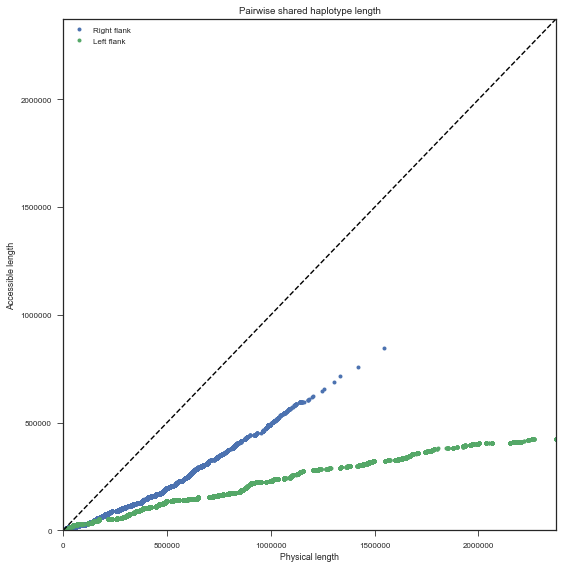

In [51]:
def pw_accessibility_diagnostics():


    # check again accessibility

    fig, ax = plt.subplots(figsize=(8, 8))
    x = pw_spd_right
    y = pw_spd_right_accessible
    ax.plot(x, y, linestyle=' ', marker='o', markersize=4, label='Right flank')
    x = pw_spd_left
    y = pw_spd_left_accessible
    ax.plot(x, y, linestyle=' ', marker='o', markersize=4, label='Left flank')
    ax.set_xlabel('Physical length')
    ax.set_ylabel('Accessible length')
    lim = 0, x.max()
    ax.set_xlim(*lim)
    ax.set_ylim(*lim)
    ax.plot(lim, lim, 'k--')
    ax.legend()
    ax.set_title('Pairwise shared haplotype length')
    fig.tight_layout()
    
    
pw_accessibility_diagnostics()

check recombination rate on left vs. right flank

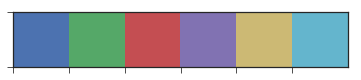

In [52]:
palette = sns.color_palette()
sns.palplot(palette);

x    0.261947
dtype: float64

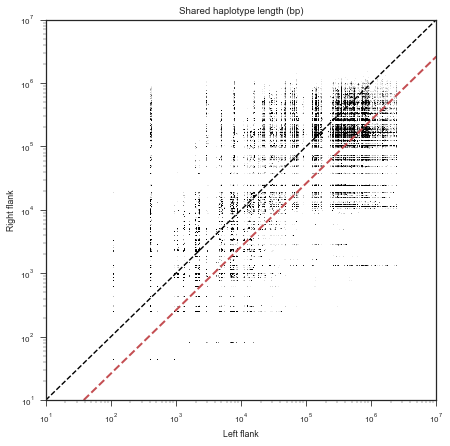

In [53]:
def pw_haplength_diagnostics():

    # compare shared haplotype length on left versus right flanks

    x = pw_spd_left
    y = pw_spd_right

    fig, ax = plt.subplots(figsize=(7, 7))
    ax.plot(x, y, marker='o', markersize=1, mfc='k', mec='k', linestyle=' ', alpha=.1)
    lim = 1e1, 1e7

    df = pandas.DataFrame({'x': x, 'y': y})
    # linear regression
    r = sfa.ols('y ~ x + 0', data=df).fit()
    # plot the regression line
    ax.plot(lim, [l * r.params['x'] for l in lim], linestyle='--', color=palette[2], lw=2)

    ax.set_xlim(*lim)
    ax.set_ylim(*lim)
    ax.plot(lim, lim, 'k--')
    ax.set_xlabel('Left flank')
    ax.set_ylabel('Right flank')
    ax.set_title('Shared haplotype length (bp)')
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    return r.params


pw_haplength_diagnostics()

x    1.007489
dtype: float64

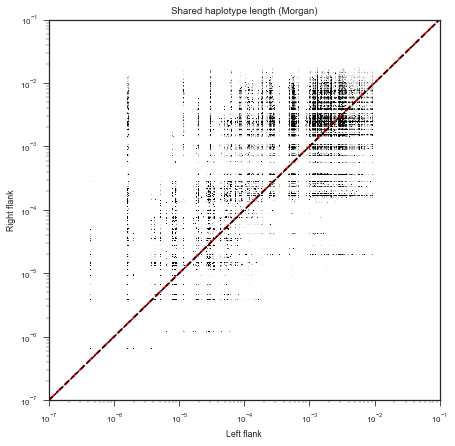

In [54]:
def pw_haplength_diagnostics_adjusted():


    # compare shared haplotype length after applying adjustment for different 
    # recombination rates on left and right flanks

    x = pw_spd_left * rr_left
    y = pw_spd_right * rr_right

    fig, ax = plt.subplots(figsize=(7, 7))
    ax.plot(x, y, marker='o', markersize=1, mfc='k', mec='k', linestyle=' ', alpha=.1)
    lim = 1e-7, 1e-1

    df = pandas.DataFrame({'x': x, 'y': y})
    r = sfa.ols('y ~ x + 0', data=df).fit()
    ax.plot(lim, [l * r.params['x'] for l in lim], linestyle='--', color='r', lw=2)

    ax.set_xlim(*lim)
    ax.set_ylim(*lim)
    ax.plot(lim, lim, 'k--')
    ax.set_xlabel('Left flank')
    ax.set_ylabel('Right flank')
    ax.set_title('Shared haplotype length (Morgan)')
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    return r.params


pw_haplength_diagnostics_adjusted()

In [55]:
# check where the heterochromatin boundary is supposed to be
phase1_ar3.tbl_chromatin

0|name,1|chrom,2|start,3|stop
CHX,X,20009764,24393108
CH2R,2R,58984778,61545105
CH2L,2L,1,2431617
PEU2L,2L,2487770,5042389
IH2L,2L,5078962,5788875


x    1.688465
dtype: float64

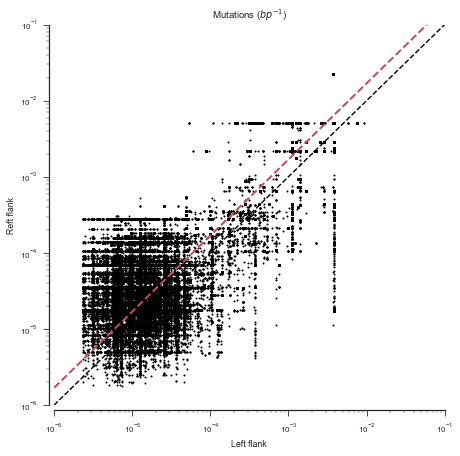

In [56]:
def pw_mutation_diagnostics():

    # check mutation rate on left versus right flank.

    x = pw_muts_left / pw_spd_left_accessible
    y = pw_muts_right / pw_spd_right_accessible
    tst = (x > 0) & (y > 0)
    x = x[tst]
    y = y[tst]

    lim = 1e-6, 1e-1
    fig, ax = plt.subplots(figsize=(7, 7))
    sns.despine(ax=ax, offset=5)
    ax.plot(x, y, marker='o', markersize=2, mfc='k', mec='k', linestyle=' ')

    df = pandas.DataFrame({'x': x, 'y': y})
    r = sfa.ols('y ~ x + 0', data=df).fit()
    ax.plot(lim, [l * r.params['x'] for l in lim], linestyle='--', color=palette[2], lw=2)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(*lim)
    ax.set_ylim(*lim)
    ax.plot(lim, lim, linestyle='--', color='k')
    ax.set_title('Mutations ($bp^{-1}$)')
    ax.set_xlabel('Left flank')
    ax.set_ylabel('Reft flank')

    return r.params


pw_mutation_diagnostics()

x    0.996194
dtype: float64

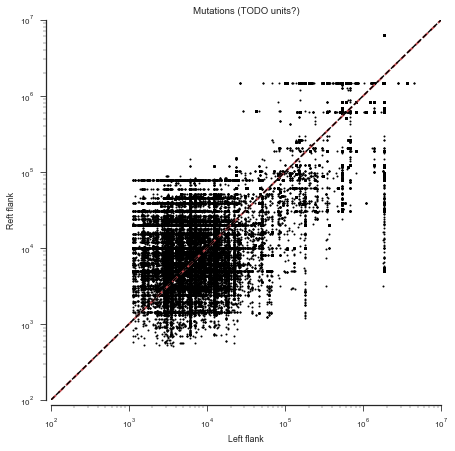

In [57]:
def pw_mutation_diagnostics_adjusted():


    # check mutations on left versus right flank after correcting mutation rate

    x = pw_muts_left / (mu_left * pw_spd_left_accessible)
    y = pw_muts_right / (mu_right * pw_spd_right_accessible)
    tst = (x > 0) & (y > 0)
    x = x[tst]
    y = y[tst]

    lim = 1e2, 1e7
    fig, ax = plt.subplots(figsize=(7, 7))
    sns.despine(ax=ax, offset=5)
    ax.plot(x, y, marker='o', markersize=2, mfc='k', mec='k', linestyle=' ')

    df = pandas.DataFrame({'x': x, 'y': y})
    r = sfa.ols('y ~ x + 0', data=df).fit()
    ax.plot(lim, [l * r.params['x'] for l in lim], linestyle='--', color=palette[2], lw=2)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(*lim)
    ax.set_ylim(*lim)
    ax.plot(lim, lim, linestyle='--', color='k')
    ax.set_title('Mutations (TODO units?)')
    ax.set_xlabel('Left flank')
    ax.set_ylabel('Reft flank')
    return r.params


pw_mutation_diagnostics_adjusted()

x    0.990074
dtype: float64

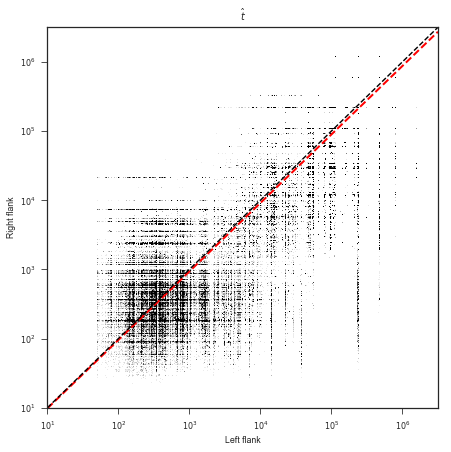

In [58]:
def pw_t_hat_diagnostics():

    # now compare estimats of t_hat on left and right flanks, using all adjustments

    pw_t_hat_left = (1 + pw_muts_left) / (2 * (pw_spd_left * rr_left + pw_spd_left_accessible * mu_left))
    pw_t_hat_right = (1 + pw_muts_right) / (2 * (pw_spd_right * rr_right + pw_spd_right_accessible * mu_right))
    x = np.log10(pw_t_hat_left)
    y = np.log10(pw_t_hat_right)

    fig, ax = plt.subplots(figsize=(7, 7))
    ax.plot(x, y, marker='o', markersize=1, mfc='k', mec='k', linestyle=' ', alpha=.1)
    lim = 1, 6.5

    df = pandas.DataFrame({'x': x, 'y': y})
    r = sfa.ols('y ~ x + 0', data=df).fit()
    ax.plot(lim, [l * r.params['x'] for l in lim], linestyle='--', color='r', lw=2)

    ax.set_xlim(*lim)
    ax.set_ylim(*lim)
    ax.plot(lim, lim, 'k--')
    ax.set_xlabel('Left flank')
    ax.set_ylabel('Right flank')
    ax.set_title('$\hat{t}$')
    ticks = np.arange(lim[0], int(lim[1]) + 1)
    ticklabels = ['$10^{%s}$' % t for t in ticks]
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticklabels)
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticklabels)
    
    return r.params


pw_t_hat_diagnostics()

In [59]:
def compute_combined_t_hat():
    global pw_t_hat_both

    # combined both flanks
    pw_muts_both = pw_muts_left + pw_muts_right
    pw_spd_both = pw_spd_left + pw_spd_right
    pw_sgl_both = pw_spd_left * rr_left + pw_spd_right * rr_right
    pw_sml_both = pw_spd_left_accessible * mu_left + pw_spd_right_accessible * mu_right
    pw_t_hat_both = (1 + pw_muts_both) / (2 * (pw_sgl_both + pw_sml_both))
    
    
compute_combined_t_hat()

In [60]:
np.savez_compressed('../../data/phase2/pairwise_haplotype_age.npz', 
                    t_hat=pw_t_hat_both)

In [61]:
!ls -lh ../../data/phase2/pairwise_haplotype_age.npz

-rw-r--r-- 1 aliman aliman 2.4M Nov  2 18:09 ../../data/phase2/pairwise_haplotype_age.npz


# Dendrogram visualisation and clustering

In [62]:
rcParams['lines.linewidth'] = .5


In [63]:
def plot_dendrogram(dist, cut_height=1e3, yscale='log', ylim=(10, 1e6), linkage_method='average',
                    n_clusters=14):
    """This function plots a dendrogram using scipy and provides some utilities for annotating clusters."""
    
    z = scipy.cluster.hierarchy.linkage(dist, method=linkage_method)

    fig = plt.figure(figsize=(16, 8), )
    gs = mpl.gridspec.GridSpec(nrows=3, ncols=1, height_ratios=[6, .5, 4], hspace=0)

    ax = fig.add_subplot(gs[0])
    sns.despine(ax=ax, offset=3, bottom=True, top=False)
    r = scipy.cluster.hierarchy.dendrogram(
        z, no_labels=True, count_sort=True, 
        color_threshold=0, 
        above_threshold_color='k',
        ax=ax, )
    ax.set_ylim(*ylim)
    ax.set_yscale(yscale)
    # ax.set_ylim(bottom=-1000)
    xmin, xmax = ax.xaxis.get_data_interval()
    xticklabels = np.array(list(range(0, len(df_haplotypes), 200)) + [len(df_haplotypes)])
    xticks = xticklabels / len(df_haplotypes)
    xticks = (xticks * (xmax - xmin)) + xmin
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_xlabel('Haplotypes')
    ax.xaxis.set_label_position('top')
    ax.set_ylabel('$\hat{t}$', rotation=0, ha='right')

    cluster_palette = sns.color_palette('Set3', n_colors=12)
    if cut_height:
        ax.axhline(cut_height, linestyle='--', color='k')
        # find clusters
        f = scipy.cluster.hierarchy.fcluster(z, cut_height, criterion='distance')
        # compute cluster sizes
        fsz = np.bincount(f)
        # sort largest first
        fsort = np.argsort(fsz)[::-1]
        # take largest n
        fsort = fsort[:n_clusters]
        # get haplotype indices for each cluster
        clusters = [set(np.nonzero(f == i)[0]) for i in fsort]
        clusters_leaves = [sorted([r['leaves'].index(i) for i in cluster])
                           for cluster in clusters]
        ixs = np.argsort([min(cl) for cl in clusters_leaves])
        clusters = [clusters[i] for i in ixs]
        clusters_leaves = [clusters_leaves[i] for i in ixs]
        for i, cluster_leaves in enumerate(clusters_leaves):
            color = cluster_palette[i % len(cluster_palette)]
            x1, x2 = min(cluster_leaves), max(cluster_leaves)
#             ax.axvline(x1*10, color='k', linestyle='--')
#             ax.axvline(x2*10, color='k', linestyle='--')
            ax.fill_between([x1*10, x2*10], 0, cut_height, color=color, alpha=.4, zorder=20)
#             ax.axvspan(x1*10, x2*10, color=color, zorder=-20, alpha=.5)
            ax.text((x1*10 + x2*10) / 2, ylim[0], str(i), ha='center', va='top')
        
    ax = fig.add_subplot(gs[1], )
    sns.despine(ax=ax, left=True, bottom=True)
    pops = df_haplotypes.population[r['leaves']]
    colors = [pop_colors[p] for p in pops]
    ax.broken_barh([(i, 1) for i in range(len(df_haplotypes))], yrange=(0, 1), color=colors)
    ax.set_xlim(0, len(df_haplotypes))
    ax.set_yticks([])
    ax.set_ylabel('Population', rotation=0, ha='right', va='center')
    ax.set_xticks([])
    if cut_height:
        for i, cluster_leaves in enumerate(clusters_leaves):
            color = cluster_palette[i % len(cluster_palette)]
            x1, x2 = min(cluster_leaves), max(cluster_leaves)
            ax.axvline(x1, color='k', linestyle='--', zorder=20)
            ax.axvline(x2, color='k', linestyle='--', zorder=20)

    ax = fig.add_subplot(gs[2])
    hapclust.plot_haplotypes(ax, haps_vgsc_missense[:, r['leaves']], lbl_vgsc_missense)
    ax.set_xlim(0, len(df_haplotypes))
    ax.set_xlabel('Haplotypes')
    if cut_height:
        for i, cluster_leaves in enumerate(clusters_leaves):
            color = cluster_palette[i % len(cluster_palette)]
            x1, x2 = min(cluster_leaves), max(cluster_leaves)
            ax.axvline(x1, color='k', linestyle='--', zorder=20)
            ax.axvline(x2, color='k', linestyle='--', zorder=20)
            ax.axvspan(x1, x2, color=color, zorder=20, alpha=.4)

    gs.tight_layout(fig, h_pad=0)
    return clusters

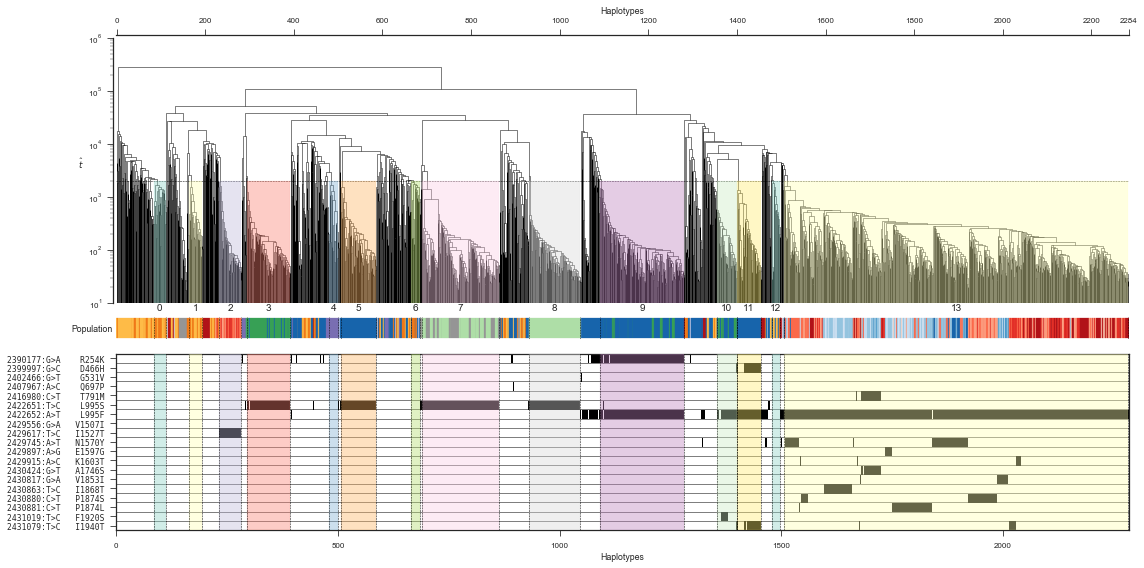

In [64]:
# canonical dendrogram we'll use for cluster analyses
clusters = plot_dendrogram(pw_t_hat_both, cut_height=2e3)

In [65]:
len(clusters)

14

In [66]:
# cluster_names = {
#     1 : 'F4',
#     2 : 'F3',
#     3 : 'F1',
#     4 : 'L2',
#     5 : 'L1',
#     7 : 'S4/5',
#     8 : 'F2',
#     9 : 'F5',
#     10 : 'S2',
#     12 : 'S1',
#     13 : 'S3'
# }

### Output the haplogroup indices for use elsewhere

In [67]:
# clust_dict = {
#     n: clusters[k] for k, n in cluster_names.items()
# }
# sorted(clust_dict)

In [68]:
# # save as pickle
# import pickle
# with open('../data/clust_dict.pickle', 'wb') as handle:
#     pickle.dump(clust_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [69]:
# # check pickle
# with open('../data/clust_dict.pickle', 'rb') as handle:
#     b = pickle.load(handle)

# print(clust_dict == b)

In [70]:
# # make list of all indices (values) and their cluster names (keys) in clusters_good 
# all_idx = []
# all_clu = []
# for n, s in clust_dict.items():
#     for i in sorted(s):
#         all_clu.append(n)
#         all_idx.append(i)
        
# len(all_idx), len(all_clu)

In [71]:
# # write out text file
# clus_df = pandas.DataFrame()
# clus_df['cluster'] = all_clu
# clus_df['haplotype'] = all_idx
# clus_df.to_csv('../data/clusters.csv', index=False)